In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import re
import seaborn as sns

# **Import Dataset**

In [6]:
df = pd.read_csv('./dataset/tweet_emotions.csv')
df.head()

,tweet_id,sentiment,content
0,1956967341,empty,@tiffanylue i know i was listenin to bad habi...
1,1956967666,sadness,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,wants to hang out with friends SOON!
4,1956968416,neutral,@dannycastillo We want to trade with someone w...


In [7]:
df = df.drop_duplicates()

In [8]:
df = df.drop(columns=['tweet_id'])

In [9]:
df['sentiment'].unique().tolist()

['empty',
 'sadness',
 'enthusiasm',
 'neutral',
 'worry',
 'surprise',
 'love',
 'fun',
 'hate',
 'happiness',
 'boredom',
 'relief',
 'anger']

In [10]:
df = df[(df['sentiment'] == 'sadness') | (df['sentiment'] == 'worry') | (df['sentiment'] == 'love') | (df['sentiment'] == 'anger') | (df['sentiment'] == 'happiness')]
df.head()

,sentiment,content
1,sadness,Layin n bed with a headache ughhhh...waitin o...
2,sadness,Funeral ceremony...gloomy friday...
5,worry,Re-pinging @ghostridah14: why didn't you go to...
6,sadness,"I should be sleep, but im not! thinking about ..."
7,worry,Hmmm. http://www.djhero.com/ is down


Text(0.5, 1.0, 'The distribution of emotions')

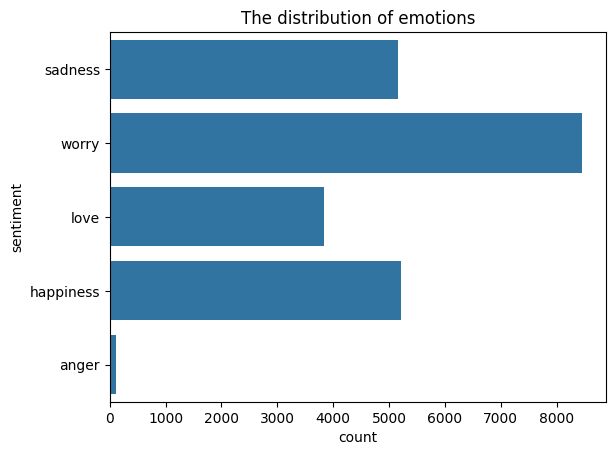

In [11]:
sns.countplot(df['sentiment'])
plt.title('The distribution of emotions')

In [12]:
anger = df[df['sentiment'] == 'anger']
anger = anger['content']
anger

494                                  fuckin'm transtelecom
527                       Working   But it's Fridaaaayyyyy
612                             Packing  I don't like it..
1377     I tried to dye my hair and all i got was a blo...
1384     &quot;locked up abroad&quot; makes bein half b...
                               ...                        
34762    my gawwddd ! 6 headshotss inna row? im on fyaa...
35160    I'm way to sleepy.. Ill watch my shows lata..G...
35913           @NerdIndian Take that back. I am insulted.
36211    @anieszkaa haha i did a ltiitle bit yesterday ...
39222    @johncmayer you are one of my favorite musicia...
Name: content, Length: 110, dtype: object

upsampling

In [15]:
from sklearn.utils import resample
class_distribution = df['sentiment'].value_counts()
print(class_distribution)

# Step 3: Upsample minority classes
# Identify the majority class size
majority_class_size = class_distribution.max()

# Upsample each minority class
upsampled_data = []

for sentiment in class_distribution.index:
    class_data = df[df['sentiment'] == sentiment]
    upsampled_class_data = resample(
        class_data,
        replace=True,  # sample with replacement
        n_samples=majority_class_size,  # match majority class size
        random_state=42  # reproducible results
    )
    upsampled_data.append(upsampled_class_data)

# Step 4: Combine and shuffle the data
balanced_data = pd.concat(upsampled_data)
balanced_data = balanced_data.sample(frac=1, random_state=42).reset_index(drop=True)

sentiment
worry        8459
happiness    5209
sadness      5165
love         3842
anger         110
Name: count, dtype: int64


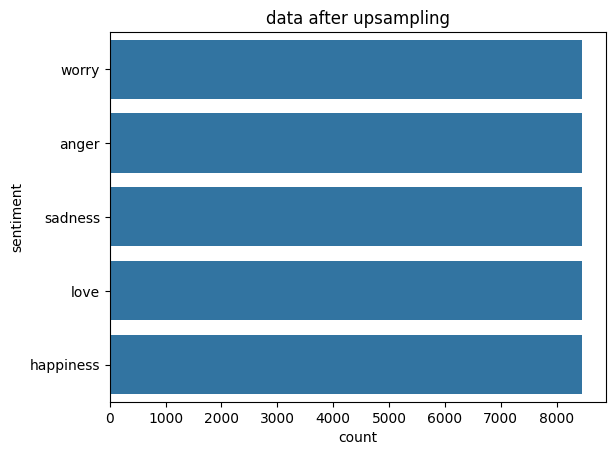

In [16]:
sns.countplot(balanced_data['sentiment'])
plt.title('data after upsampling')
plt.show()

In [17]:
balanced_data['sentiment'].value_counts()

sentiment
worry        8459
anger        8459
sadness      8459
love         8459
happiness    8459
Name: count, dtype: int64

In [18]:
happiness = balanced_data[balanced_data['sentiment']=='anger']
happiness = happiness['content']


# Preprocess Text

## Text Cleaning

**Text before cleaning**

In [31]:
print(df['content'][1])
print(df['sentiment'][1])

Layin n bed with a headache  ughhhh...waitin on your call...
sadness


In [19]:
def clean_text(text):

    text = text.lower()

    text = re.sub(r'<.*?>', '', text)

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)

    # Remove special characters, punctuation, and numbers
    text = re.sub(r'[^a-z\s]', '', text)

    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

balanced_data['content'] = balanced_data['content'].apply(clean_text)

**Text after cleaned**

In [32]:
print(balanced_data['content'][1])

buddy i hear you it pisses me off haha


## Split dataset

In [33]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(balanced_data, test_size=0.2)

In [34]:
X_train = df_train['content']
y_train = df_train['sentiment']
X_test = df_test['content']
y_test = df_test['sentiment']

In [35]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)

In [36]:
encoder.classes_

array(['anger', 'happiness', 'love', 'sadness', 'worry'], dtype=object)

# Tokenizing

In [37]:
vocab_size = 5000
oov_tok = '<OOV>'
padding = 'post'

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train)

In [38]:
len(tokenizer.word_index)

24771

In [39]:
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

# Padding

In [40]:
X_train = pad_sequences(X_train, maxlen=200, padding=padding),
X_test = pad_sequences(X_test, maxlen=200, padding=padding)

# Model

In [43]:
embedding_dim = 32

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(200,), dtype='int32'),
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),

    tf.keras.layers.Dense(embedding_dim, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
])
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 200, 32)        │       160,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 64)             │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 178,885 (698.77 KB)

 Trainable params: 178,885 (698.77 KB)

 Non-trainable params: 0 (0.00 B)

In [44]:
model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])
num_epochs = 20
batch_size = 256
history = model.fit(X_train, y_train, epochs=num_epochs, validation_data=(X_test, y_test), verbose=2)

Epoch 1/20


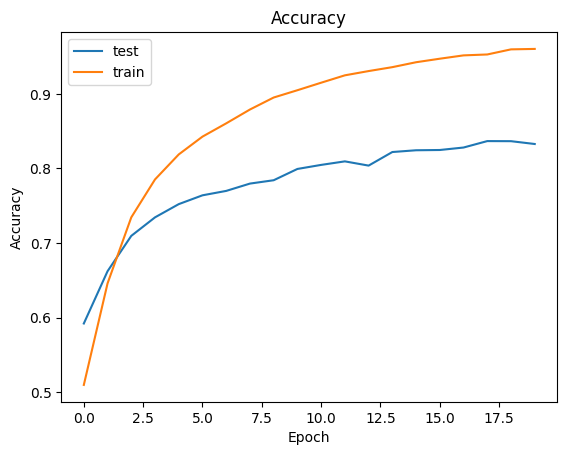

In [ ]:
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['accuracy'])
plt.plot()
plt.title('Accuracy')
plt.legend(['test', 'train'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

265/265 [==============================] - 2s 7ms/step


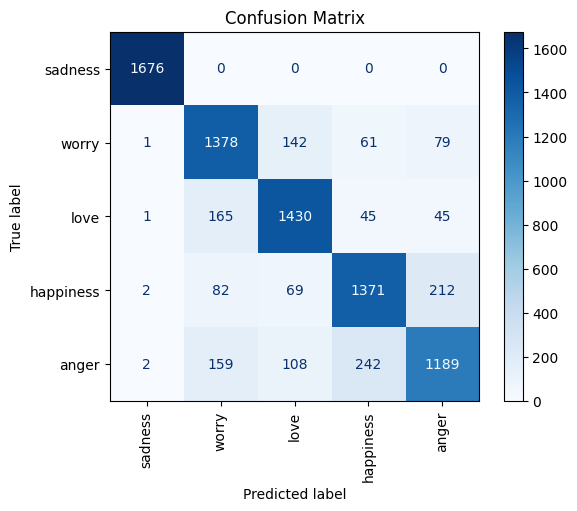

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Step 3: Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)
ConfusionMatrixDisplay(conf_matrix, display_labels=df['sentiment'].unique().tolist()).plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.xticks(rotation=90)
plt.show()

In [ ]:
sentences = [
            "she left me",
            "i'm happy now, i got accepted in my dream company",
            "i'm scared that AI will replaced us in the future",
            "i do really like her",
            "Wow, I'm absolutely thrilled that the internet decided to crash right in the middle of my important video call. Couldn't have asked for better timing!",
            "she really pisses me off",
            "I'm so fed up with how unreliable this service is! I can't believe we're paying for this level of incompetence. It's infuriating to deal with constant issues and zero accountability."
            ]
for sentence in sentences:
  print(sentence)
  sentence = clean_text(sentence)
  sentence = tokenizer.texts_to_sequences([sentence])
  sentence = pad_sequences(sentence, maxlen=229, padding='post')
  pred = np.max(model.predict(sentence))
  result = encoder.inverse_transform(np.argmax(model.predict(sentence), axis=-1))[0]
  print(f'emotion prediction: {result} probability: {pred}\n\n')

she left me
1/1 [==============================] - 0s 41ms/step
emotion prediction: sadness probability: 0.5371782779693604


i'm happy now, i got accepted in my dream company
1/1 [==============================] - 0s 32ms/step
emotion prediction: happiness probability: 0.9971840977668762


i'm scared that AI will replaced us in the future
1/1 [==============================] - 0s 34ms/step
emotion prediction: happiness probability: 0.9971838593482971


i do really like her
1/1 [==============================] - 0s 23ms/step
emotion prediction: love probability: 0.7316790223121643


Wow, I'm absolutely thrilled that the internet decided to crash right in the middle of my important video call. Couldn't have asked for better timing!
1/1 [==============================] - 0s 22ms/step
emotion prediction: sadness probability: 0.99992835521698


she really pisses me off
1/1 [==============================] - 0s 21ms/step
emotion prediction: worry probability: 0.9999970197677612


I'm so fed

In [ ]:
import json

with open('tokenizer_dict.json', 'w') as file:
    json.dump(tokenizer.word_index, file)

In [ ]:
model.save('sanityMate-model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
